In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables - use Base.prepare and autoload_with engine created in last cell
Base.prepare(autoload_with=engine)

In [8]:
# View all of the classes that automap found - use Base.classes.keys()
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table - use Base.classes and then 
#respective class to assign the automapped DBs to variables
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
#Use Session(bind=engine) to create a Session Object
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [41]:
#Ran this to get column names
#first_row = session.query(Measurement).first()
#first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1f17c99fd30>,
 'tobs': 65.0,
 'station': 'USC00519397',
 'date': '2010-01-01',
 'prcp': 0.08,
 'id': 1}

In [38]:
# Find the most recent date in the data set.
#Use session.query to query the Measurement DB date column
#then use .order_by(Measurement.date.desc()).first() to get the latest date
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23',)

Text(0, 0.5, 'Inches')

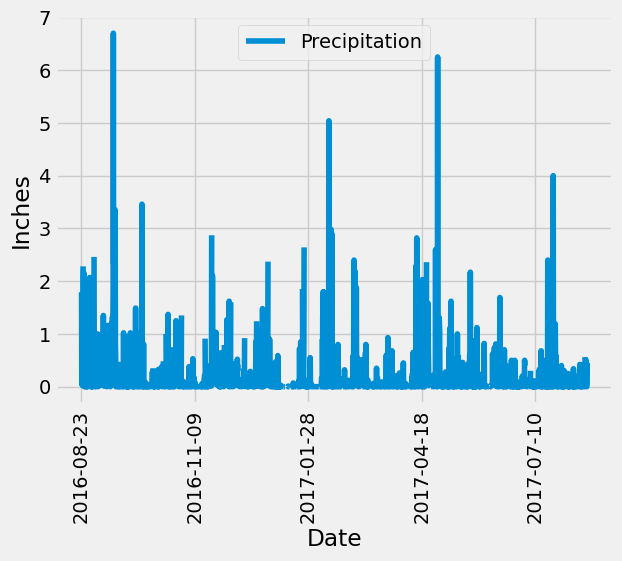

In [221]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.
#convert to datetime using the date from the last cell
latest_date= dt.date(2017,8,23) 


# Calculate the date one year from the last date in data set.
#subtract one year from latest_date using dt.timedelta
one_year_ago = latest_date - dt.timedelta(days=365)


# Perform a query to retrieve the data and precipitation scores
#Only need date and prcp from Measurement
#filter on date >= one_year_ago
results = session.query(Measurement.date,Measurement.prcp).\
    filter(Measurement.date>=one_year_ago).all()

# Save the query results as a Pandas DataFrame and set column names for DataFrame
prcpDB = pd.DataFrame(results,columns=["Date","Precipitation"])

#Sort dataframe by date using .sort_values() function on the "Date" column
prcpDB = prcpDB.sort_values("Date")

# # Use Pandas Plotting with Matplotlib to plot the data
prcpDB.plot(x="Date", y="Precipitation", rot = 90) #
plt.xlabel("Date")
plt.ylabel("Inches")


In [154]:
# Use Pandas to calcualte the summary statistics for the precipitation data
# Use .agg function with list of desired aggregates
prcp_col = prcpDB["Precipitation"]
summary_stats = pd.DataFrame(prcp_col.\
                agg(["count","mean","std","min", "max"]))

#get quartile values to be added to summary_stats
quartiles = prcp_col.quantile([0.25, 0.5,0.75])

#use .loc to set the value at the desired summary_stat row name
# (and column with name Precipitation)
summary_stats.loc['25%','Precipitation'] = quartiles[0.25]
summary_stats.loc['50%','Precipitation'] = quartiles[0.5]
summary_stats.loc['75%','Precipitation'] = quartiles[0.75]

summary_stats


,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
max,6.700000
25%,0.000000
50%,0.020000
75%,0.130000


# Exploratory Station Analysis

In [155]:
#Ran this to get column names
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1f104d61fa0>,
 'latitude': 21.2716,
 'id': 1,
 'elevation': 3.0,
 'station': 'USC00519397',
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168}

In [163]:
# Design a query to calculate the total number stations in the dataset
session.query(Station.station).count()

9

In [204]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

#output of query is the station and the number of rows in Measurement
#that uses that station
#start by querying for the Measurement station and count of Measurement stations
##group by the Measurement station
## and order from highest to lowest count

#save output as a variable to use later
station_count = session.query(Measurement.station,func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

station_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [207]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

#Most active station is stored in first tuple of station_count
(most_active, count) = station_count[0]

#Use func to show lowest, highest, and average temps from that station
session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active).all()

[(54.0, 85.0, 71.66378066378067)]

Text(0.5, 1.0, 'Temperatures at Station USC00519281')

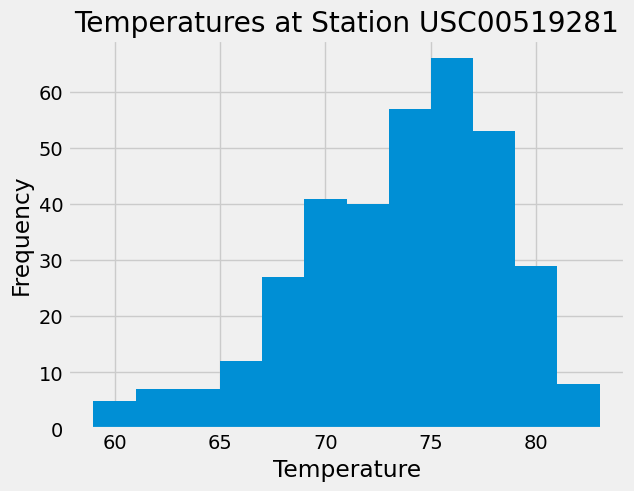

In [218]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

#already imported dt, but also need table from pandas.plotting
from pandas.plotting import table

results = session.query(Measurement.tobs).\
    filter(Measurement.station==most_active).\
    filter(Measurement.date>=one_year_ago).all()
tobs = pd.DataFrame(results)
tobs.hist(bins=12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.title(f"Temperatures at Station {most_active}")


# Close session

In [219]:
# Close Session
session.close()